<a href="https://www.kaggle.com/code/annamalkova88/psychopathy-prediction-my-vers?scriptVersionId=129636573" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The model should aim to identify people scoring high in Psychopathy, for the purpose of this competition, defined as 2 SD's above a mean of 1.98. This accounts for roughly 3% of the entire sample and therefore the challenge with this dataset is developing a model to work with a highly imbalanced dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly 
import plotly.express as px

# Data info

In [3]:
df = pd.read_csv('/kaggle/input/twitter-psychopathy-prediction/PersonalityData_ExternalVersion001.csv')

In [4]:
df.head()

,uid,psychopathy,machiavellianism,narcissism,openness,conscientiousness,extraversion,agreeableness,neuroticism,Var1,...,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100
0,1,2.444444,3.4,3.444444,7.0,6.0,5.5,3.5,3.5,48.59,...,4.86,1.31,2.05,0.66,0.92,1.14,4.37,0.71,15.11,45.70
1,2,1.888889,2.4,2.777778,7.0,4.5,6.0,3.0,5.5,41.29,...,8.28,0.04,0.46,2.34,2.99,0.38,1.46,2.83,21.90,53.49
2,3,1.111111,3.0,3.444444,5.5,6.0,6.0,6.5,3.0,14.65,...,3.07,0.20,2.63,1.72,0.64,0.42,2.74,0.11,10.13,32.77
3,4,1.888889,3.0,2.444444,5.0,3.5,2.0,6.5,1.5,17.60,...,1.65,0.16,1.43,2.42,1.07,1.67,3.46,0.35,5.65,32.67
4,5,2.111111,3.1,1.333333,6.0,5.5,2.5,5.5,5.0,52.63,...,1.12,0.08,1.14,0.38,0.85,1.05,4.67,0.38,8.34,34.25


In [5]:
df['psycho_status'] = df['psychopathy'].apply(lambda x: 1 if x>1.98 else 0)

In [6]:
df.describe()

,uid,psychopathy,machiavellianism,narcissism,openness,conscientiousness,extraversion,agreeableness,neuroticism,Var1,...,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,psycho_status
count,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2593.000000,...,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2927.000000
mean,1464.000000,1.975819,2.792552,2.726645,5.510420,4.674411,4.090707,4.726341,3.688931,26.023351,...,0.268619,1.287746,2.803750,1.198581,0.806000,2.804400,0.439915,13.082058,39.984219,0.476597
std,845.096444,0.590817,0.601120,0.611013,1.096339,1.389679,1.616798,1.211883,1.512482,13.078465,...,0.461726,0.781928,2.669118,1.271677,1.026422,1.241658,0.590839,6.178866,13.245530,0.499537
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,732.500000,1.555556,2.400000,2.333333,5.000000,3.500000,3.000000,4.000000,2.500000,13.960000,...,0.050000,0.870000,1.157500,0.550000,0.280000,2.020000,0.180000,9.390000,33.750000,0.000000
50%,1464.000000,1.888889,2.800000,2.777778,5.500000,4.500000,4.000000,4.500000,3.500000,23.670000,...,0.150000,1.200000,2.110000,0.950000,0.620000,2.835000,0.330000,12.450000,38.755000,0.000000
75%,2195.500000,2.333333,3.200000,3.111111,6.500000,6.000000,5.500000,5.500000,5.000000,36.960000,...,0.350000,1.590000,3.622500,1.540000,1.070000,3.630000,0.530000,15.850000,44.512500,1.000000
max,2927.000000,4.666667,5.000000,4.777778,7.000000,7.000000,7.000000,7.000000,7.000000,69.860000,...,16.130000,14.000000,34.950000,38.360000,30.140000,12.500000,14.810000,100.000000,352.050000,1.000000


In [7]:
temp = df['psycho_status'].value_counts(normalize = True)
temp

0    0.523403
1    0.476597
Name: psycho_status, dtype: float64

In [8]:
fig = px.histogram(data_frame = df,
                   x = 'psycho_status', 
                   color = 'psycho_status'
                  )
fig.show()

In [9]:
mask = list(df.loc[:, 'openness':'neuroticism'].columns)
fig = px.box(data_frame = df,
                   x = mask
                  )
fig.show()

In [10]:
mask = list(df.loc[:, 'psychopathy':'narcissism'].columns)
fig = px.box(data_frame = df,
                   x = mask
                  )
fig.show()

In [13]:
mask = list(df.loc[:, 'psychopathy':'neuroticism'].columns)
fig = px.box(data_frame = df,
                   x = mask,
             color = 'psycho_status'
                  )
fig.show()

<function matplotlib.pyplot.show(close=None, block=None)>

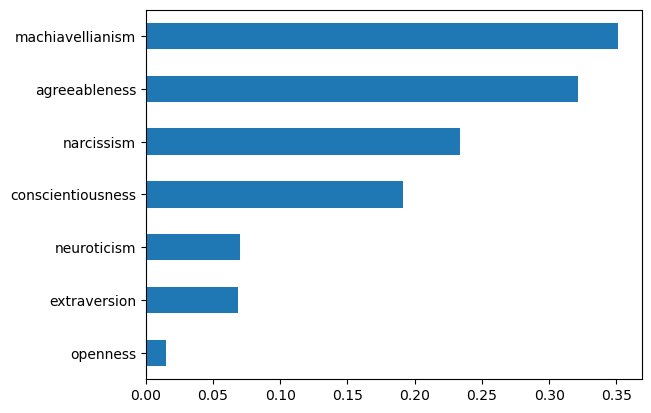

In [14]:
mask = list(df.loc[:, 'machiavellianism':'neuroticism'].columns)
df.corr()['psycho_status'][mask].apply(lambda x: abs(x)).sort_values().plot.barh()
plt.show

<AxesSubplot:>

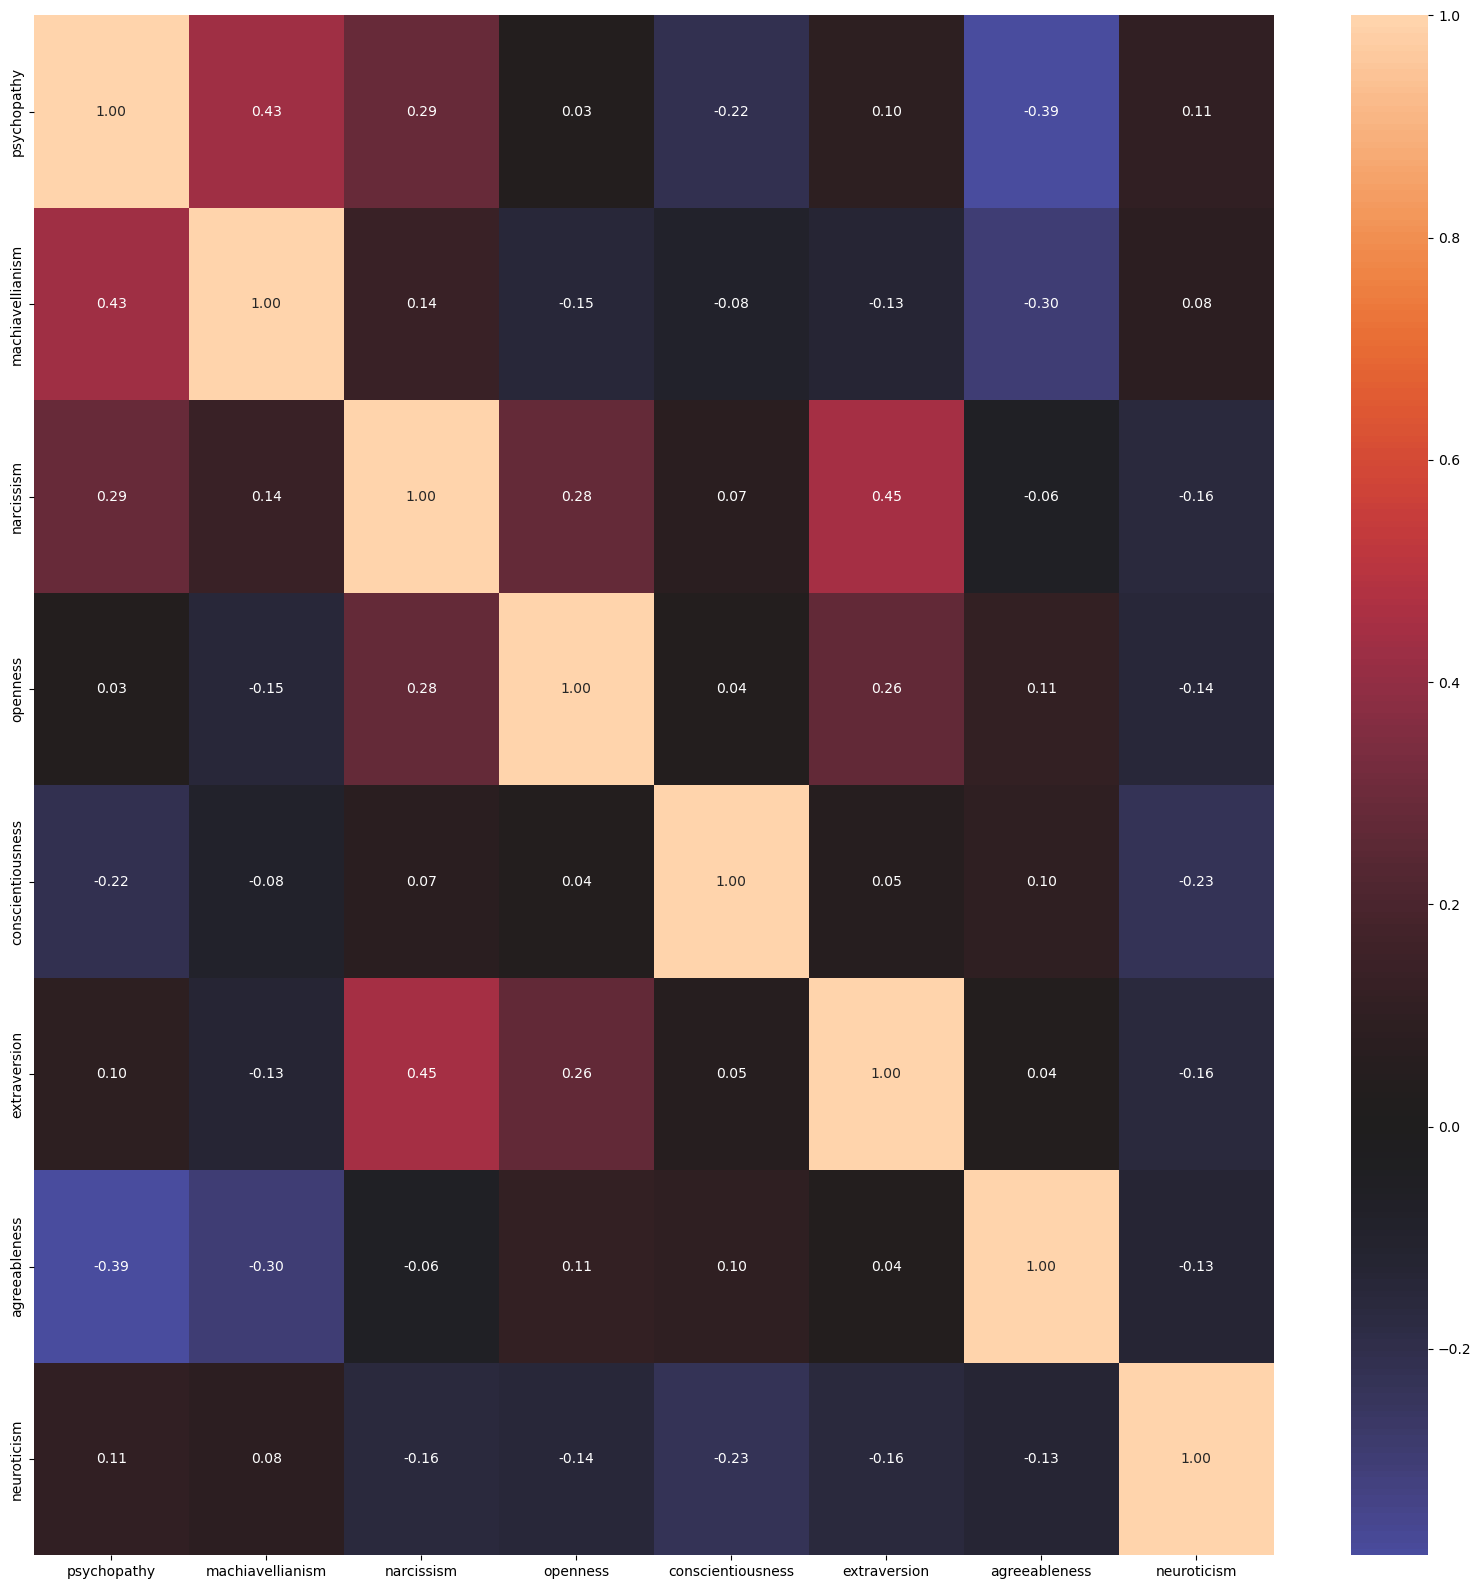

In [17]:
mask = list(df.loc[:, 'psychopathy':'neuroticism'].columns)
plt.figure(figsize=(20,20))  
sns.heatmap(df[mask].corr(),fmt='.2f',annot=True, center=0)

# EDA

Work with NaN

In [18]:
a = df.isnull().mean()*100
b = a[a>0].sort_values(ascending = False)
b[b>1]

Var1     11.411001
Var53    11.171848
Var75    11.171848
Var74    11.171848
Var73    11.171848
           ...    
Var8     10.693543
Var9     10.693543
Var2     10.693543
Var11    10.693543
Var12    10.693543
Length: 91, dtype: float64

In [19]:
mask = list(df.loc[:, 'Var1':'Var100'].columns)

In [20]:
for el in mask:
    df[el] = df[el].fillna(df[el].mode().iloc[0])

In [21]:
a = df.isnull().mean()*100
b = a[a>0].sort_values(ascending = False)
b

Series([], dtype: float64)

In [ ]:
#check for categorical
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

In [ ]:
df['Var20'] = df['Var20'].apply(lambda x: 1 if x=='1' else 0)

In [ ]:
df = df.drop(['uid'],axis = 1)

In [51]:
df = df.drop(['psychopathy'],axis = 1)

# Classification

In [52]:
X = df.drop(['psycho_status'], axis=1)
y = df['psycho_status']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(X_train.shape, 
      X_test.shape)
print(y_train.value_counts(normalize = True), 
      y_test.value_counts(normalize = True))

(1961, 107) (966, 107)
0    0.523202
1    0.476798
Name: psycho_status, dtype: float64 0    0.52381
1    0.47619
Name: psycho_status, dtype: float64


In [53]:
#normalization
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns= X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [54]:
# Logistic regression
log_reg = linear_model.LogisticRegression(random_state=42, solver = 'sag', max_iter=1000)

log_reg.fit(X_train_scaled, y_train)

y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_train, y_pred_train))
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1026
           1       0.71      0.69      0.70       935

    accuracy                           0.71      1961
   macro avg       0.71      0.71      0.71      1961
weighted avg       0.71      0.71      0.71      1961

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       506
           1       0.70      0.68      0.69       460

    accuracy                           0.71       966
   macro avg       0.71      0.71      0.71       966
weighted avg       0.71      0.71      0.71       966



In [55]:
# Decision Tree
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42,
    max_depth=11
)

dt_clf.fit(X_train_scaled, y_train)
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_train, y_pred_train))
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1026
           1       0.71      0.69      0.70       935

    accuracy                           0.71      1961
   macro avg       0.71      0.71      0.71      1961
weighted avg       0.71      0.71      0.71      1961

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       506
           1       0.70      0.68      0.69       460

    accuracy                           0.71       966
   macro avg       0.71      0.71      0.71       966
weighted avg       0.71      0.71      0.71       966



# Ansambles

In [56]:
# Random forest
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=100, 
    criterion='gini',
    max_depth=10, 
    max_features='sqrt', 
    random_state=42, 
    min_samples_leaf = 5
)

rf_clf_full.fit(X_train_scaled, y_train)


y_pred_test = rf_clf_full.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.75      0.71       506
           1       0.69      0.61      0.65       460

    accuracy                           0.68       966
   macro avg       0.68      0.68      0.68       966
weighted avg       0.68      0.68      0.68       966



In [57]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

gb = GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    max_depth=5, 
    random_state=42, 
    min_samples_leaf = 5
)

gb.fit(X_train_scaled, y_train)

y_pred_test = gb.predict(X_test_scaled)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       506
           1       0.67      0.65      0.66       460

    accuracy                           0.69       966
   macro avg       0.68      0.68      0.68       966
weighted avg       0.69      0.69      0.69       966



In [58]:
# Optuna optimization
import optuna
random_state = 42
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

print("The best hyperparameters {}".format(study.best_params))
print("f1_score for train sample: {:.2f}".format(study.best_value))

[I 2023-05-15 11:32:37,420] A new study created in memory with name: RandomForestClassifier
[I 2023-05-15 11:32:39,314] Trial 0 finished with value: 0.9989293361884368 and parameters: {'n_estimators': 154, 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9989293361884368.
[I 2023-05-15 11:32:40,941] Trial 1 finished with value: 0.9438444924406049 and parameters: {'n_estimators': 158, 'max_depth': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9989293361884368.
[I 2023-05-15 11:32:42,655] Trial 2 finished with value: 0.955304254173398 and parameters: {'n_estimators': 162, 'max_depth': 17, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9989293361884368.
[I 2023-05-15 11:32:43,936] Trial 3 finished with value: 0.9865374259558428 and parameters: {'n_estimators': 110, 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9989293361884368.
[I 2023-05-15 11:32:45,105] Trial 4 finished with value: 0.9421308815575988 and parameters: {'n_e

The best hyperparameters {'n_estimators': 134, 'max_depth': 23, 'min_samples_leaf': 2}
f1_score for train sample: 1.00


In [60]:
# metrics for test sample
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy for test samples: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score for test samples: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy for test samples: 0.68
f1_score for test samples: 0.64


# Stacking

In [59]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('dt',  DecisionTreeClassifier(
        criterion='entropy', 
        random_state=42,
        max_depth=10)),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05, 
        n_estimators=300, 
        max_depth=5, 
        random_state=42, 
        min_samples_leaf = 5)),
    ('log', LogisticRegression(
        random_state=42,
        solver = 'sag', 
        max_iter=1000
    ))
]


reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
                                          random_state=42)
)

reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('log',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag'))],
                   final_estimator=LogisticRegression(random_state=42))

In [61]:
y_pred_stack = reg.predict(X_test_scaled)

print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       506
           1       0.71      0.68      0.69       460

    accuracy                           0.71       966
   macro avg       0.71      0.71      0.71       966
weighted avg       0.71      0.71      0.71       966



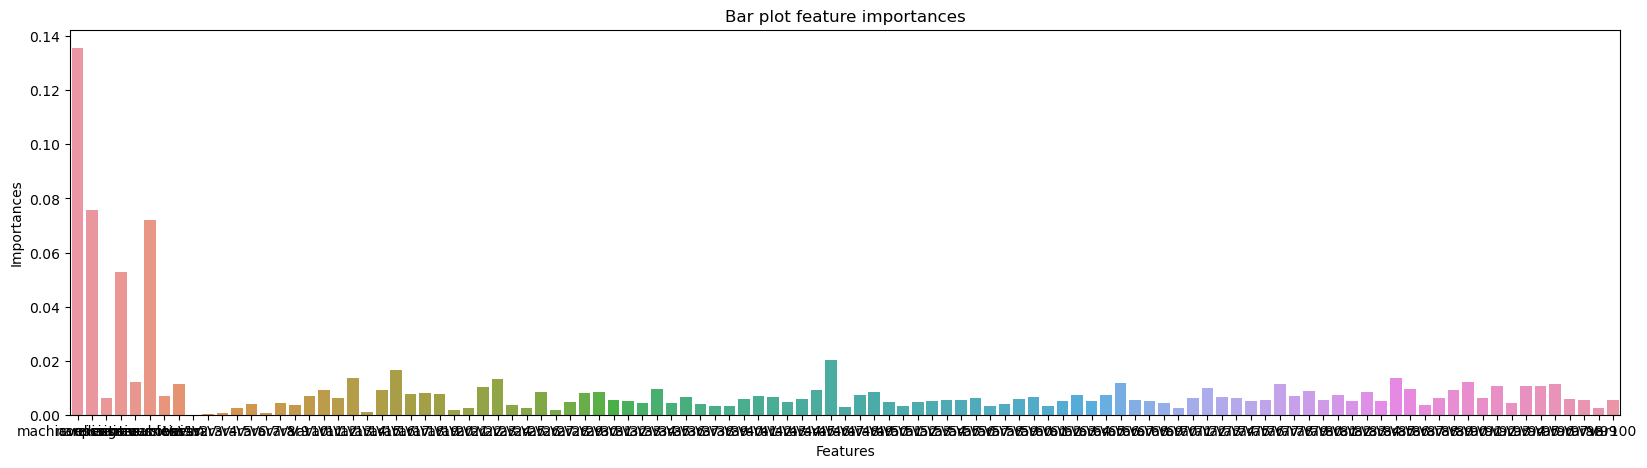

In [62]:
# evaluate which features show the greatest importance in the gradient boosting model
fig, ax = plt.subplots(figsize=(20, 5)) 
feature = X_train_scaled.columns 
feature_importances = gb.feature_importances_ 

sns.barplot(x=feature, y=feature_importances, ax=ax);

ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

In [ ]:
from sklearn.decomposition import PCA

# создадим объект класса PCA
pca = PCA(n_components=3)

# уменьшим размерность данных
train_x_pca = pca.transform(train_x)
test_x_pca = pca.transform(test_x)

# Clusterization

In [ ]:
k_clust = 2
kmean= KMeans(k_clust)
kmean.fit(X) 
labels=kmean.labels_

In [ ]:
clusters=pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

# Regression Techniques

In [ ]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor

import xgboost as xgb

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, f_classif
# Importing DataScience libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,skew
from scipy import stats
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV, ElasticNetCV, LassoCV,BayesianRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,LabelEncoder,OrdinalEncoder,power_transform
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
import warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
y = df['psychopathy']
X = df.drop(['psychopathy'], axis = 1)

In [ ]:
y.shape

In [ ]:
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, list(y), test_size=0.2)

In [ ]:
X_temp.shape

In [ ]:
X_test.shape

In [ ]:
len(y_temp)

In [ ]:
len(y_test)

### Multiple Regression

In [ ]:
linear = linear_model.LinearRegression().fit(X_temp, y_temp)
print("Multiple:", cross_val_score(linear, X_test, y_test).mean())

### Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np
poly = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])
print("Polynomial:", cross_val_score(poly, X_test, y_test).mean())

### Ridge Regression

In [ ]:
ridge = Ridge(alpha=300, fit_intercept=True, max_iter=20000, solver='saga').fit(X_temp, y_temp)
print("Ridge:", cross_val_score(ridge, X_test, y_test).mean())

### LASSO Regression

In [ ]:
lasso = linear_model.Lasso(alpha =0.0005, random_state=1).fit(X_temp, y_temp)
print("LASSO:", cross_val_score(lasso, X_test, y_test).mean())